![title](images/header.png)

# Vb - Supervised Classification with CAFI data
-------
this notebook performs a supervised classification of probability of forest change for one country using the merged eSBAE and CEO data trained on the interpreted data from CAFI DDD phase I (2015-2020).  
The change probability is then divided into 3 strata using kmeans
The modeled data are exported to csv for the following script to extract samples for validation in CEO.

This script requires an m16 or r16 instance to run
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


### Parameters

#### Import the CEO validated data from CAFI DDD first phase
##### this file includes 13,115 points, randomly distributed over CAFI, with interpretation
##### this file is available here: https://drive.google.com/file/d/1D1tkVVhKv6QNCQhLLfRo7eqz0VO3XZZF/view?usp=sharing
##### unzip and upload to your SEPAL workspace using Filezilla

In [2]:
trn_ceo = pd.read_csv('/home/sepal-user/CAFI_DDD/all_ceo_validation_TMF_2023_uniqueID.csv', delimiter=',')
trn_ceo

,OID,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Code,Ref_FNF,Ref_LCover,Ref_Change_Type,...,Ref_IndAg,Ref_ArtFor,Ref_IndFor,Ref_ArtMin,Ref_IndMin,Ref_Other,Source,Ref_Change_Year,Change_Bin,UniqueID
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg2018,1,1
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg2020,1,2
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,...,0,1,0,0,0,0,ceo,Deg2020,1,3
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,...,0,0,0,0,0,0,ceo,Stable,0,4
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,...,0,0,0,0,0,0,ceo,Stable,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13110,13110,0,,18.903293,4.178378,COD,1,1,1,Stable,...,0,0,0,0,0,0,TMF,Stable,0,13112
13111,13111,0,,17.177452,-5.075795,COD,1,1,1,Stable,...,0,0,0,0,0,0,TMF,Stable,0,13113
13112,13112,0,,21.966910,3.213589,COD,1,1,1,Stable,...,0,0,0,0,0,0,TMF,Stable,0,13114
13113,13113,0,,27.818445,-3.425143,COD,1,1,1,Stable,...,0,0,0,0,0,0,TMF,Stable,0,13115


#### CAFI augmented dataset (2015-2020)
##### this geojson file can be downloaded here: https://drive.google.com/file/d/1fEDJSnHVR8AqmqPKbeOvVtRGvrdieYwm/view?usp=sharing
##### unzip and upload to your SEPAL workspace using FileZilla

In [3]:
trn_gdf = py_helpers.geojson_to_gdf('/home/sepal-user/module_results/esbae/CAFI/CAFI_esbae_1520.geojson')
trn_gdf.columns

Index(['geometry', 'UniqueID', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

### Augmented dataset for country of interest (2015-2022)
#### this is the output folder from eSBAE script 4

In [4]:
# glob all files in the data augmentation output folder
#files = Path('/home/sepal-user/module_results/esbae/GAB/04_Dataset_Augmentation/Landsat/').glob('*geojson')
files = Path('/home/sepal-user/module_results/esbae/DRC/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/COG/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/EQG/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/CMR/04_Dataset_Augmentation/Landsat/').glob('*geojson')
#files = Path('/home/sepal-user/module_results/esbae/CAR/04_Dataset_Augmentation/Landsat/').glob('*geojson')

### Land cover data to assign LC classes to points
##### the land cover classification can be downloaded here: https://drive.google.com/file/d/1St-KuG_x-Hw2_89vu-3Q-lHmBOTSisF1/view?usp=sharing
##### caution - the land cover map is very large
##### unzip it and upload to your SEPAL workspace using Filezilla
##### or use your own layer

In [5]:
LC_map = "/home/sepal-user/data/lc_map/CAFI_LC_2015_19_wgs84.tif"

#### name of output file
##### this file consists of the eSBAE data for your country with a modeled change probability using CAFI phase I data

In [6]:
all_points_out_file = '/home/sepal-user/module_results/esbae/DRC/DRC_esbae_1520_model.csv'

In [7]:
parquet_out = '/home/sepal-user/module_results/esbae/DRC/DRC_esbae.parquet'

In [8]:
# eSBAE columns for analysis
eSBAE_analysis = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    'images', 'mon_images', 'bfast_change_date',
      # 'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 'CAFI_LC_2015']

In [9]:
#eSBAE columns to include in data export
cols_to_export = ['geometry', 'UniqueID',
                  #'dates', 'ts',
                  'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub']

#### end of parameters

# 1 - CEO data preparation
### 1.1 - Import CEO interpreted data

In [10]:
len(trn_gdf.index)

13115

In [11]:
len(trn_ceo.index)

13115

In [12]:
trn_gdf = trn_gdf[cols_to_export]

### 1.2 - Inspect CEO interpreted data

Our ultimate goal is to use the CEO data for getting the probability of forest change via a series of classifications and their probability output. . , i.e. Forest-Non-Forest and a Change-No-Change classifcation.
Therefore we need to extract and trnasform the relevant information into a column of 0s and 1s. 

First let's look at the columns the CEO file contains.

In [13]:
trn_ceo.columns

Index(['OID', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Code',
       'Ref_FNF', 'Ref_LCover', 'Ref_Change_Type', 'Ref_Year', 'countDrivers',
       'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor',
       'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source',
       'Ref_Change_Year', 'Change_Bin', 'UniqueID'],
      dtype='object')

In [14]:
trn_ceo['UniqueID'].nunique(dropna=False)

13115

In [15]:
trn_gdf['UniqueID'].nunique(dropna=False)

13115

### 1.3 Print unique values for columns of interest generate Change-No Change

In [16]:
# show unique values for the columns (in red)
print('Change', trn_ceo['Ref_Change_Type'].unique())

Change ['Deg' 'Stable' 'NF' 'Def']


In [17]:
# add stable forest column for classification
trn_ceo['Stable_Bin'] = trn_ceo['Ref_Change_Type'].apply(lambda x: 1 if x == 'Stable' else 0)
np.unique(trn_ceo['Stable_Bin'], return_counts=True)

(array([0, 1]), array([8446, 4669]))

In [18]:
# add def column for classification
trn_ceo['Def_Bin'] = trn_ceo['Ref_Change_Type'].apply(lambda x: 1 if x == 'Def' else 0)
np.unique(trn_ceo['Def_Bin'], return_counts=True)

(array([0, 1]), array([10574,  2541]))

In [19]:
# add def column for classification
trn_ceo['Deg_Bin'] = trn_ceo['Ref_Change_Type'].apply(lambda x: 1 if x == 'Deg' else 0)
np.unique(trn_ceo['Deg_Bin'], return_counts=True)

(array([0, 1]), array([11816,  1299]))

In [20]:
trn_join = pd.merge(trn_ceo,trn_gdf, left_on='UniqueID', right_on='UniqueID',how='outer')
len(trn_join.index)

13115

In [21]:
trn_join.head()

,OID,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Code,Ref_FNF,Ref_LCover,Ref_Change_Type,...,slope,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,1,6,6,6,6,6,0.0,0.0,70.0,91.0
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,1,6,6,6,6,6,0.0,0.0,70.0,91.0
2,2,47,NaN,22.791831,7.078410,CAF,149,1,11,Deg,...,2,6,6,6,6,6,0.0,0.0,70.0,91.0
3,3,279,NaN,27.430102,-6.534839,COD,11,1,11,Stable,...,1,6,6,6,6,6,0.0,0.0,70.0,91.0
4,4,224,NaN,22.212148,-9.940982,COD,11,1,11,Stable,...,2,6,6,6,6,6,0.0,0.0,70.0,91.0


# 2 - Join CEO and Time-Series data

### 2.1 - Load data augmented time-series data from script 4
area must intersect with the CAFI region

In [22]:
# prepare for parallel execution
files = [[str(file), False] for file in files]

# read files in parallel nad put the in a list
result = py_helpers.run_in_parallel(
    py_helpers.geojson_to_gdf,
    files,
    workers=4,
    parallelization='processes'
)

# concatenate dataframes from result's list
cdf = pd.concat(result)

In [23]:
#save file
cdf.to_parquet(parquet_out)

In [ ]:
#if you already ran this step you can read the parquet file
#pd.read_parquet(parquet_out)

In [24]:
len(cdf.index)

1973273

In [25]:
print(cdf.columns)

Index(['geometry', 'point_id', 'dates', 'ts', 'images', 'mon_images',
       'bfast_change_date', 'bfast_magnitude', 'bfast_means',
       'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 'red_mean',
       'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min',
       'nir_max', 'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max',
       'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 'ndfi_mean',
       'ndfi_sd', 'ndfi_min', 'ndfi_max', 'brightness_mean', 'brightness_sd',
       'brightness_min', 'brightness_max', 'greenness_mean', 'greenness_sd',
       'greenness_min', 'greenness_max', 'wetness_mean', 'wetness_sd',
       'wetness_min', 'wetness_max', 'bs_slope_mean', 'bs_slope_sd',
       'bs_slope_max', 'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'a

In [26]:
print(trn_gdf.columns)

Index(['geometry', 'UniqueID', 'images', 'mon_images', 'bfast_change_date',
       'bfast_magnitude', 'bfast_means', 'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       

In [27]:
print(trn_ceo.columns)

Index(['OID', 'PLOTID', 'CEO_PLOTID', 'LON', 'LAT', 'ISO', 'CEO_Ref_Code',
       'Ref_FNF', 'Ref_LCover', 'Ref_Change_Type', 'Ref_Year', 'countDrivers',
       'Ref_InfraR', 'Ref_Urb', 'Ref_ArtAg', 'Ref_IndAg', 'Ref_ArtFor',
       'Ref_IndFor', 'Ref_ArtMin', 'Ref_IndMin', 'Ref_Other', 'Source',
       'Ref_Change_Year', 'Change_Bin', 'UniqueID', 'Stable_Bin', 'Def_Bin',
       'Deg_Bin'],
      dtype='object')


### 2.2 - Make a union with training data

In [28]:
eSBAE_cols = [
    #'geometry', 
    #'point_id', 
    #'dates', 'ts', 
    'images', 'mon_images', 'bfast_change_date','bfast_magnitude', 'bfast_means', 
       'cusum_change_date',
       'cusum_confidence', 'cusum_magnitude', 'red_mean', 'red_sd', 'red_min',
       'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean',
       'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd',
       'swir2_min', 'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min',
       'ndfi_max', 'brightness_mean', 'brightness_sd', 'brightness_min',
       'brightness_max', 'greenness_mean', 'greenness_sd', 'greenness_min',
       'greenness_max', 'wetness_mean', 'wetness_sd', 'wetness_min',
       'wetness_max', 'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max',
       'bs_slope_min', 'ewma_jrc_date', 'ewma_jrc_change',
       'ewma_jrc_magnitude', 'mosum_jrc_date', 'mosum_jrc_change',
       'mosum_jrc_magnitude', 'cusum_jrc_date', 'cusum_jrc_change',
       'cusum_jrc_magnitude', 'ccdc_change_date', 'ccdc_magnitude', 'aspect',
       'dw_class_mode', 'dw_tree_prob__max', 'dw_tree_prob__min',
       'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 'elevation', 'esa_lc20',
       'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20',
       'esri_lc21', 'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00',
       'lang_tree_height', 'potapov_tree_height', 'slope',
       'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020',
       'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub']

In [29]:
harm_cols = eSBAE_cols + ['geometry','point_id','Change_Bin','Def_Bin','Deg_Bin']
#cols_to_harmonize

In [30]:
#cdf['UniqueID'] = 0
cdf['Change_Bin'] = float('nan')
cdf['Def_Bin'] = float('nan')
cdf['Deg_Bin'] = float('nan')
trn_join['point_id']= 0

db = pd.concat([cdf[harm_cols],trn_join[harm_cols]])

In [31]:
len(db.index)

1986388

In [32]:
trn_join.head(2)

,OID,PLOTID,CEO_PLOTID,LON,LAT,ISO,CEO_Ref_Code,Ref_FNF,Ref_LCover,Ref_Change_Type,...,tmf_2016,tmf_2017,tmf_2018,tmf_2019,tmf_2020,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,point_id
0,0,311,NaN,25.602120,-11.691888,COD,147,1,11,Deg,...,6,6,6,6,6,0.0,0.0,70.0,91.0,0
1,1,53,NaN,19.012978,6.404943,CAF,149,1,11,Deg,...,6,6,6,6,6,0.0,0.0,70.0,91.0,0


In [33]:
db.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude',
       'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude',
       'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tre

In [34]:
len(cdf.index)+len(trn_join.index) == len(db.index)

True

#### 2.2a - assign 2015 land cover to all points 
##### this step is an optional step for stratifying forest types 

In [35]:
src = rasterio.open(LC_map)

In [36]:
coord_list = [(x, y) for x, y in zip(db["geometry"].x, db["geometry"].y)]

In [37]:
db["CAFI_LC_2015"] = [x for x in src.sample(coord_list)]
db["CAFI_LC_2015"] = db["CAFI_LC_2015"].str[0]
db.head()

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,...,tmf_defyear,tmf_degyear,tmf_main,tmf_sub,geometry,point_id,Change_Bin,Def_Bin,Deg_Bin,CAFI_LC_2015
0,143,107,2016.079,-61.259880,-2.558426,2021.575,0.534613,3939.410325,9823.183155,153.956357,...,0.0,0.0,10.0,10.0,POINT (20.44080 -0.36956),1770848,NaN,NaN,NaN,8
1,161,118,-1.000,0.000000,0.000000,2022.956,0.459192,2342.136421,9946.520763,101.978435,...,0.0,0.0,10.0,10.0,POINT (20.42110 -0.36955),1770722,NaN,NaN,NaN,8
2,158,111,2019.321,-442.680328,-1.126137,2018.225,0.437804,6594.300000,9815.459459,313.631572,...,0.0,0.0,10.0,10.0,POINT (20.43095 -0.36956),1770785,NaN,NaN,NaN,8
3,151,111,2018.992,43.459530,0.008405,2017.414,0.572650,5210.683655,9861.655298,182.976607,...,0.0,0.0,10.0,10.0,POINT (20.43600 -0.37928),1770847,NaN,NaN,NaN,8
4,151,108,2019.189,80.413734,0.152626,2018.707,0.445449,4516.905093,9836.536574,210.281957,...,0.0,0.0,10.0,10.0,POINT (20.44586 -0.37929),1770910,NaN,NaN,NaN,1


In [38]:
print(db.columns)

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude',
       'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude',
       'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tre

In [39]:
db['CAFI_LC_2015'].value_counts(dropna=False)

CAFI_LC_2015
1     881220
13    180302
19    167846
4     165722
15    116008
3     105844
8      91941
2      67092
11     52724
16     36052
18     33845
5      30253
9      23833
14     20023
6       7453
17      4424
12      1173
7        616
0         17
Name: count, dtype: int64

### 2.3 Check the amount of ground truth data we have for each class

In [40]:
np.unique(db['Change_Bin'], return_counts=True)

(array([ 0.,  1., nan]), array([   9275,    3840, 1973273]))

In [41]:
np.unique(db['Def_Bin'], return_counts=True)

(array([ 0.,  1., nan]), array([  10574,    2541, 1973273]))

In [42]:
np.unique(db['Deg_Bin'], return_counts=True)

(array([ 0.,  1., nan]), array([  11816,    1299, 1973273]))

### Run change/no-change classification

In [43]:
# predictors used change/nochange classification
db['chg_prob_cafi1520'] = clf.binary_probability_classification(db, 'Change_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.7875714830346932


In [44]:
# predictors used change/nochange classification
db['def_prob_cafi1520'] = clf.binary_probability_classification(db, 'Def_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.7575295463210064


In [45]:
# predictors used change/nochange classification
db['deg_prob_cafi1520'] = clf.binary_probability_classification(db, 'Deg_Bin', eSBAE_analysis, outlier=False)

OOB Score is 0.6846359130766299


In [46]:
clf_db = db[db["point_id"] > 0]

#### plot the change probability
a good model will have many points with low probability of change, and then very few points with higher probabilites

array([<Axes: title={'center': 'chg_prob_cafi1520'}>], dtype=object)

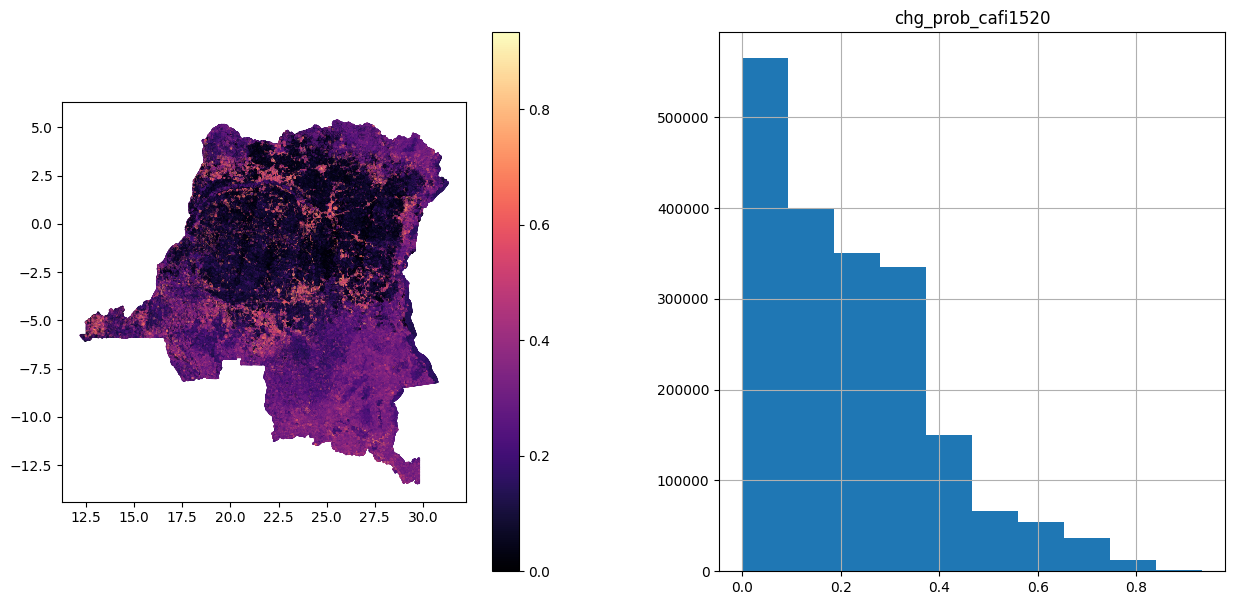

In [47]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('chg_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('chg_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'def_prob_cafi1520'}>], dtype=object)

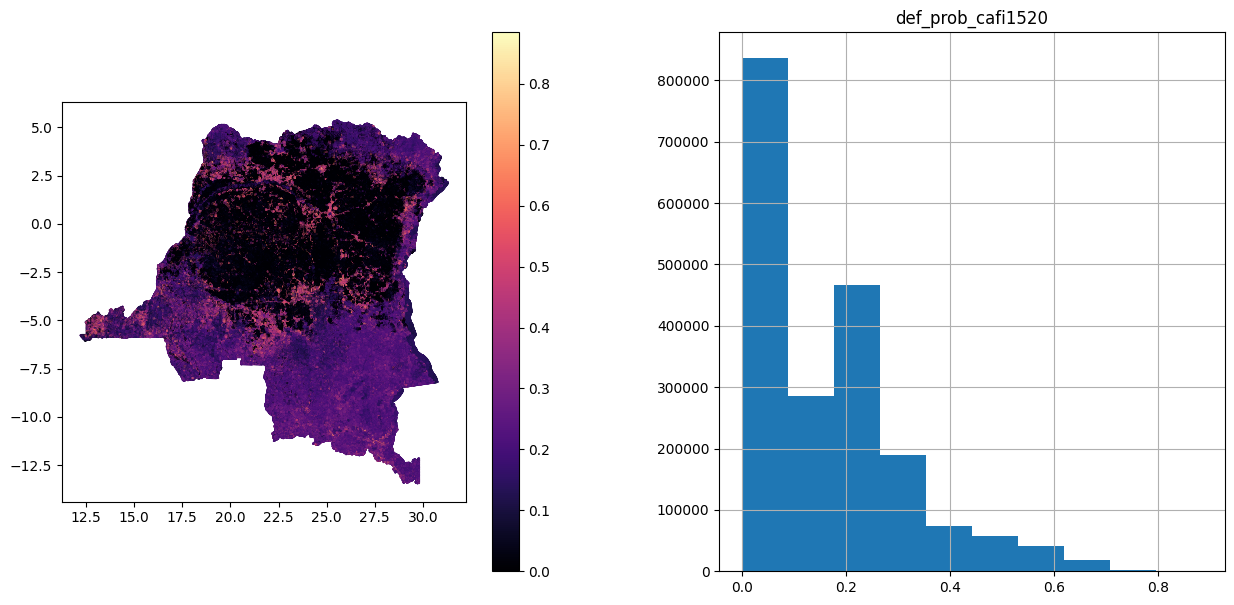

In [48]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('def_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('def_prob_cafi1520', ax=ax[1])

array([<Axes: title={'center': 'deg_prob_cafi1520'}>], dtype=object)

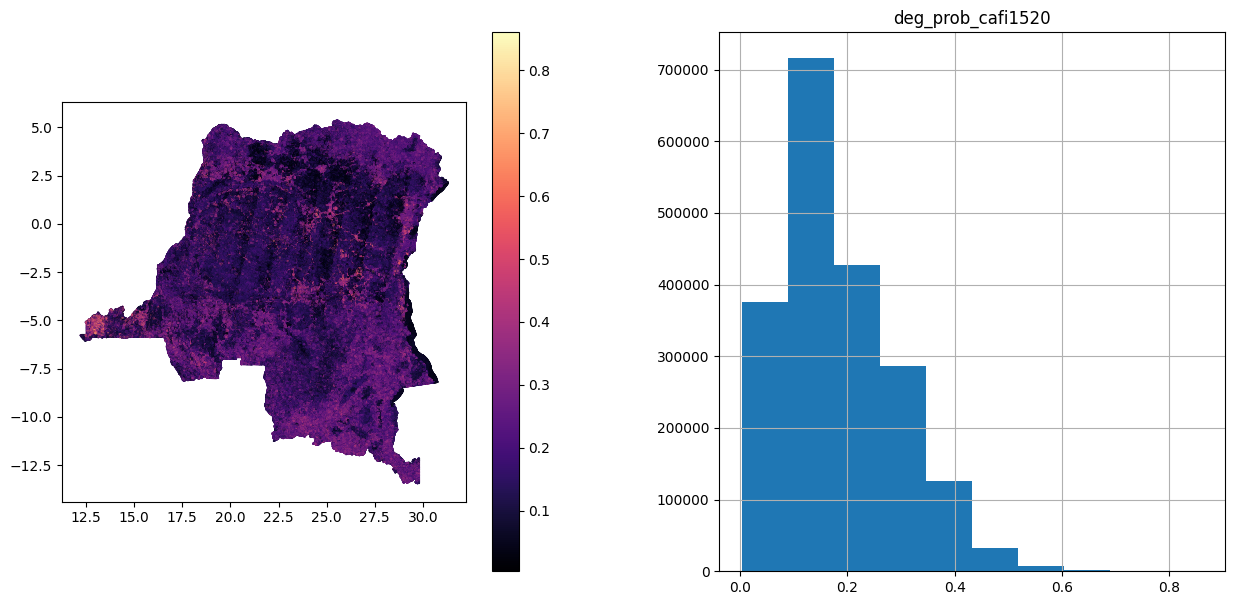

In [49]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

clf_db.plot('deg_prob_cafi1520', markersize=0.05, ax=ax[0], legend=True, cmap='magma')
clf_db.hist('deg_prob_cafi1520', ax=ax[1])

In [50]:
clf_db.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude',
       'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude',
       'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tre

In [51]:
joined_df = clf_db

In [52]:
joined_df['simple_combined'] = joined_df['chg_prob_cafi1520']

In [53]:
len(joined_df)

1973273

In [54]:
joined_df

,images,mon_images,bfast_change_date,bfast_magnitude,bfast_means,cusum_change_date,cusum_confidence,cusum_magnitude,red_mean,red_sd,...,geometry,point_id,Change_Bin,Def_Bin,Deg_Bin,CAFI_LC_2015,chg_prob_cafi1520,def_prob_cafi1520,deg_prob_cafi1520,simple_combined
0,143,107,2016.079,-61.259880,-2.558426,2021.575,0.534613,3939.410325,9823.183155,153.956357,...,POINT (20.44080 -0.36956),1770848,NaN,NaN,NaN,8,0.042000,0.008667,0.053333,0.042000
1,161,118,-1.000,0.000000,0.000000,2022.956,0.459192,2342.136421,9946.520763,101.978435,...,POINT (20.42110 -0.36955),1770722,NaN,NaN,NaN,8,0.044667,0.007333,0.053333,0.044667
2,158,111,2019.321,-442.680328,-1.126137,2018.225,0.437804,6594.300000,9815.459459,313.631572,...,POINT (20.43095 -0.36956),1770785,NaN,NaN,NaN,8,0.094667,0.037333,0.099333,0.094667
3,151,111,2018.992,43.459530,0.008405,2017.414,0.572650,5210.683655,9861.655298,182.976607,...,POINT (20.43600 -0.37928),1770847,NaN,NaN,NaN,8,0.077333,0.015333,0.094000,0.077333
4,151,108,2019.189,80.413734,0.152626,2018.707,0.445449,4516.905093,9836.536574,210.281957,...,POINT (20.44586 -0.37929),1770910,NaN,NaN,NaN,1,0.094667,0.002667,0.144667,0.094667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,264,176,2017.671,163.449188,0.524668,2023.455,0.333833,53189.217857,6202.068831,2234.039116,...,POINT (28.49083 -5.84216),3197199,NaN,NaN,NaN,4,0.318667,0.204667,0.290000,0.318667
24996,261,173,2017.014,-1354.778564,-2.604720,2019.403,0.297332,79112.577581,3513.678709,3524.003342,...,POINT (28.48627 -5.87227),3197233,NaN,NaN,NaN,15,0.282000,0.232667,0.187333,0.282000
24997,264,172,2016.688,-823.066956,-1.575796,2019.447,0.154578,59813.479056,4891.240933,3125.191263,...,POINT (28.49098 -5.86230),3197234,NaN,NaN,NaN,4,0.389333,0.241333,0.309333,0.389333
24998,266,177,2018.438,-67.072884,-0.387217,2019.447,0.376266,58609.744895,6147.980165,2316.761874,...,POINT (28.49569 -5.85234),3197235,NaN,NaN,NaN,4,0.430000,0.344667,0.368667,0.430000


### Stratify with Kmeans

In [55]:
sample_size_no = 10000

In [56]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'chg_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [57]:
joined_df['kmeans_chg'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,1001340,0.089571,0.052015,52085.071954,1,4293,5074
1,777559,0.301566,0.064238,49948.967702,2,4117,3940
2,194374,0.583345,0.099152,19272.546596,3,1588,985


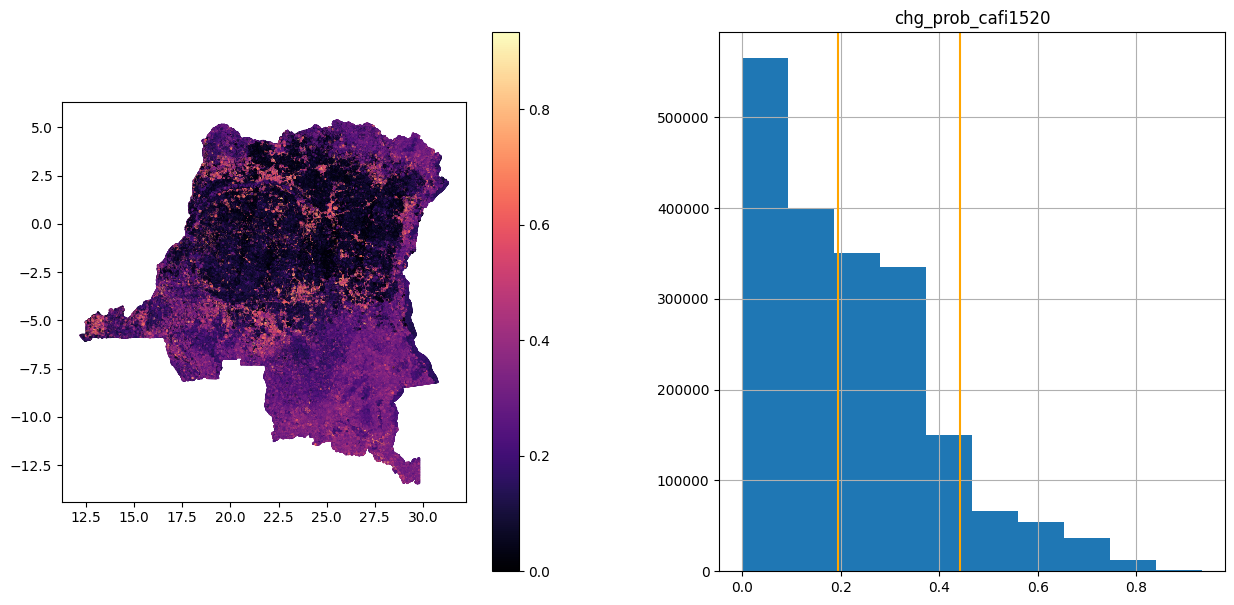

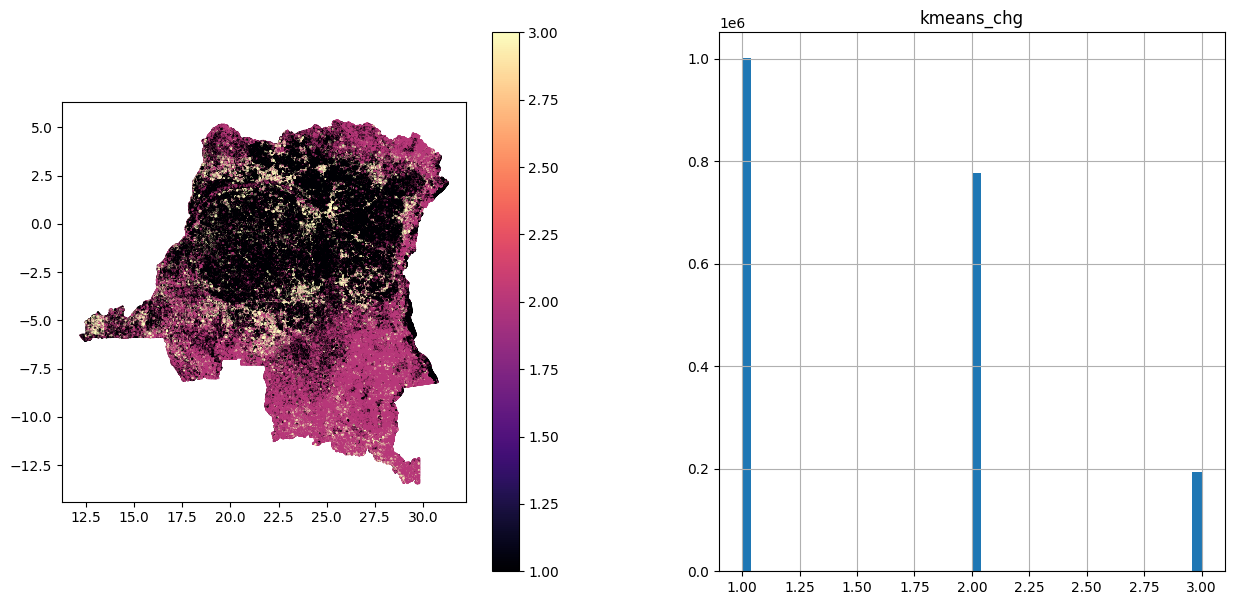

In [58]:
h.plot_cluster(joined_df, prob_column='chg_prob_cafi1520', strata_column='kmeans_chg')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_chg', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_chg', ax=ax[1], bins=50)
samples

In [59]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'def_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [60]:
joined_df['kmeans_def'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,929486,0.028657,0.032832,30516.642163,1,3200,4710
2,853943,0.223320,0.055223,47157.152598,2,4945,4327
1,189844,0.492079,0.093129,17679.978606,3,1854,962


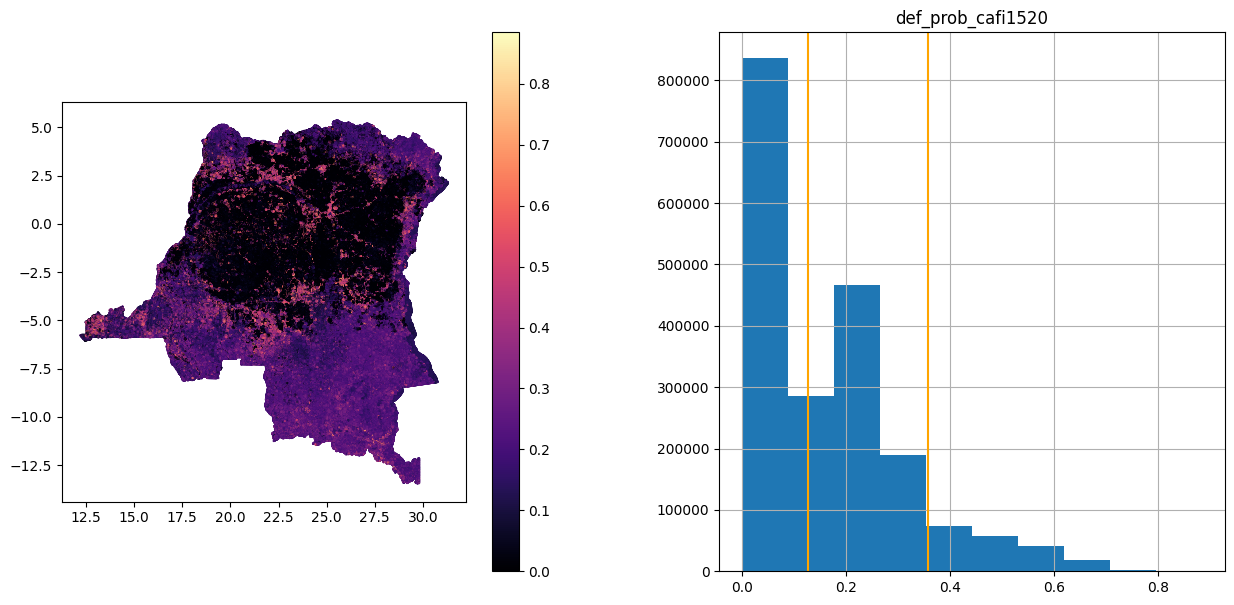

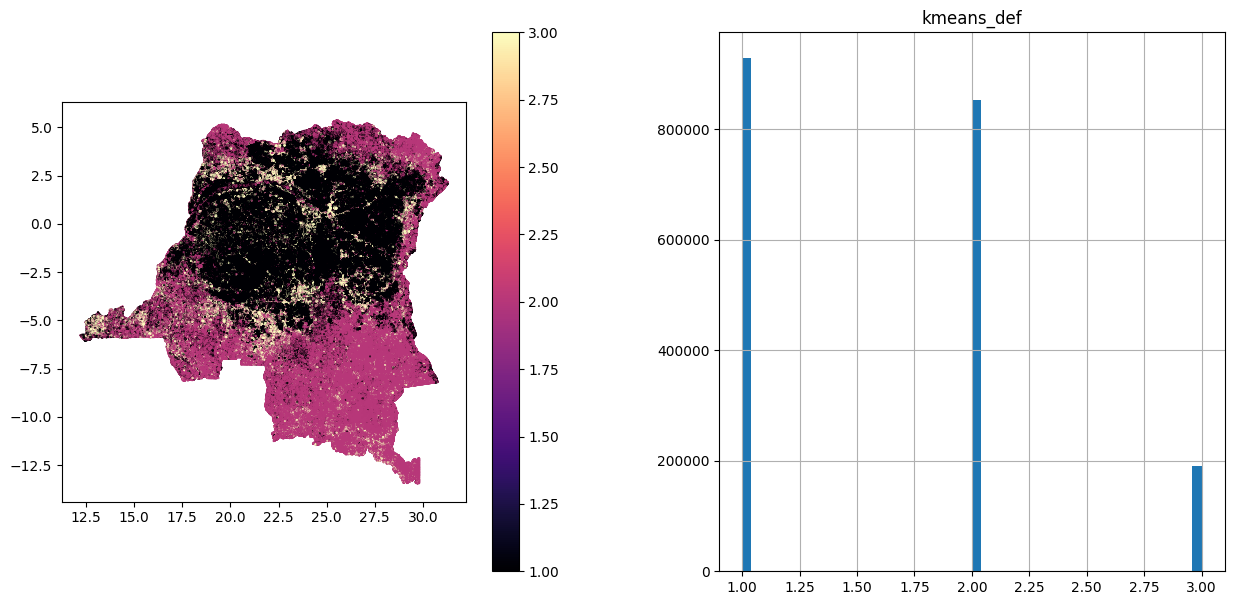

In [61]:
h.plot_cluster(joined_df, prob_column='def_prob_cafi1520', strata_column='kmeans_def')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_def', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_def', ax=ax[1], bins=50)
samples

In [62]:
joined_df, samples = h.kmeans_stratifier(joined_df, 'deg_prob_cafi1520', strata=3, sample_size=sample_size_no)

In [63]:
joined_df['kmeans_deg'] = joined_df['stratum']

,Nh,mean,SD,div,stratum,neyman,proportional
0,904755,0.094166,0.035768,32361.339708,1,3907,4585
1,686612,0.206117,0.037603,25818.348969,2,3117,3479
2,381906,0.353442,0.064537,24646.971698,3,2975,1935


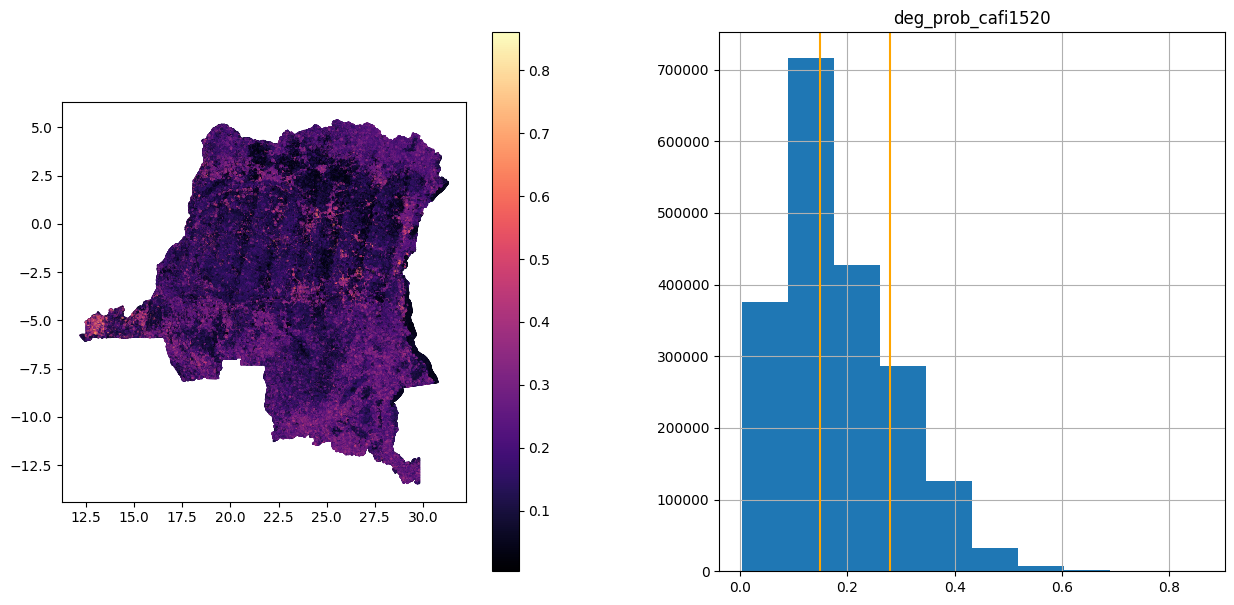

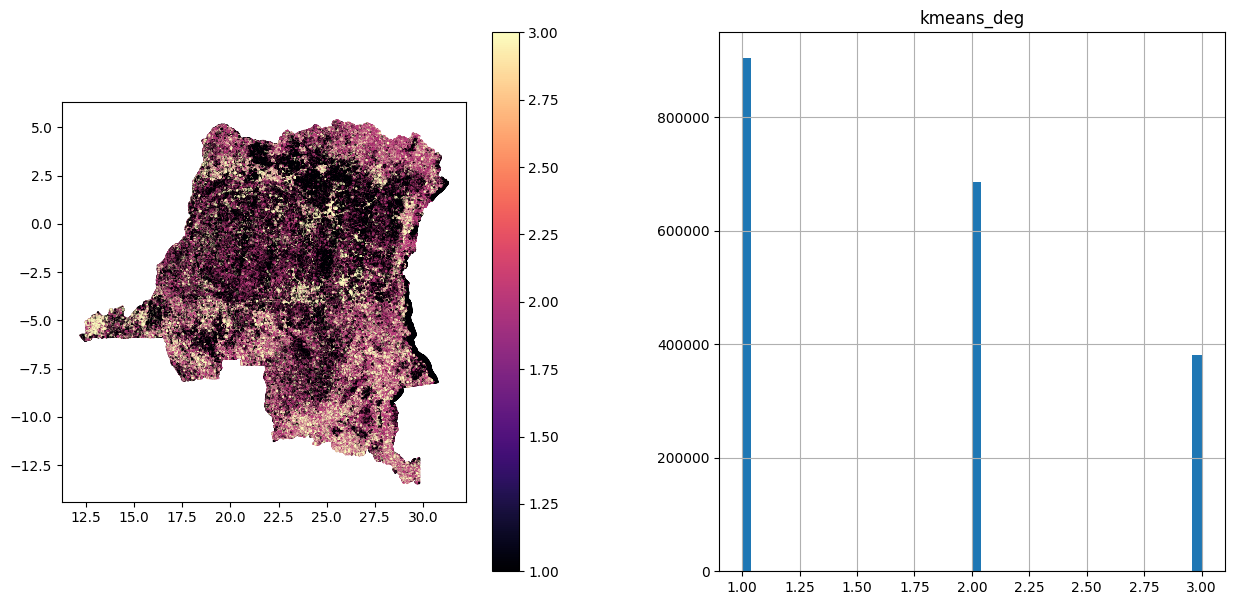

In [64]:
h.plot_cluster(joined_df, prob_column='deg_prob_cafi1520', strata_column='kmeans_deg')

fig, ax = plt.subplots(1,2, figsize=(15,7))

joined_df.plot('kmeans_deg', markersize=0.15, ax=ax[0], legend=True, cmap='magma')
joined_df.hist('kmeans_deg', ax=ax[1], bins=50)
samples

In [65]:
cross_tab = pd.crosstab(index= joined_df['kmeans_def'], columns=joined_df['kmeans_deg'], margins=True, margins_name="Total")
cross_tab

kmeans_deg,1,2,3,Total
kmeans_def,,,,
1,657824,246412,25250,929486
2,246379,397440,210124,853943
3,552,42760,146532,189844
Total,904755,686612,381906,1973273


In [66]:
pd.pivot_table(joined_df,values='point_id',index=['kmeans_chg'],aggfunc="count", margins=True)

,point_id
kmeans_chg,
1,1001340
2,777559
3,194374
All,1973273


### align column names, get coordinates


In [67]:
joined_df['PLOTID'] = joined_df['point_id']

In [68]:
joined_df.columns

Index(['images', 'mon_images', 'bfast_change_date', 'bfast_magnitude',
       'bfast_means', 'cusum_change_date', 'cusum_confidence',
       'cusum_magnitude', 'red_mean', 'red_sd', 'red_min', 'red_max',
       'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 'swir1_mean', 'swir1_sd',
       'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min',
       'swir2_max', 'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max',
       'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max',
       'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max',
       'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max',
       'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min',
       'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude',
       'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude',
       'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude',
       'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode',
       'dw_tre

In [69]:
joined_df.drop(columns='stratum', inplace=True)

In [70]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

#### export the points for your area with the change probability model

In [71]:
joined_df.to_csv(all_points_out_file,index=False)

### now you may proceed to script 5c if you want to extract sample points for CEO